In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from numba import jit,njit

In [13]:
output_path = '/home/bruce1996/data/MCI/fig/'

In [2]:
metaphlan_output = "/home/bruce1996/data/MCI/metaphlan_result/formated_mci_metaphlan_table.txt"
meta_df = pd.read_csv(metaphlan_output,sep = '\t',index_col=0)
meta_df.columns = [x.split('_')[0] for x in meta_df.columns]
metadata = pd.read_csv("/home/bruce1996/data/MCI/metadata/MCI_label_upgrade.txt",sep = '\t',index_col=0)
meta_df = meta_df.loc[:,metadata.index]

In [7]:
mci_idx = np.where(metadata['Diagnosis'].values == 'MCI',True,False)
normal_idx = np.where(metadata['Diagnosis'].values == 'Normal',True,False)

mci_matrix = meta_df.loc[:,mci_idx]
normal_matrix = meta_df.loc[:,normal_idx]
normal_matrix = normal_matrix.drop(['TPMIC01024'],axis=1)

In [9]:
normal_output_path = '/home/bruce1996/data/MCI/manuscript/normal/'
mci_output_path = '/home/bruce1996/data/MCI/manuscript/MCI/'

### output lacto & bifido information from metaphalan abundance matrix

In [10]:
lacto_idx = [bool(re.search('Lactobacillus',x)) for x in meta_df.index]
bifido_idx = [bool(re.search('Bifidobacterium',x)) for x in meta_df.index]

normal_matrix.loc[lacto_idx,:].to_csv(normal_output_path + 'abundance_matrix/lactobacillus_matrix.txt',sep='\t')
normal_matrix.loc[bifido_idx,:].to_csv(normal_output_path + 'abundance_matrix/bifidobacterium_matrix.txt',sep='\t')

mci_matrix.loc[lacto_idx,:].to_csv(mci_output_path + 'abundance_matrix/lactobacillus_matrix.txt',sep='\t')
mci_matrix.loc[bifido_idx,:].to_csv(mci_output_path + 'abundance_matrix/bifidobacterium_matrix.txt',sep='\t')

### description of probiotics characteri

In [25]:
from math import log10
def abundance_prevalence_scatterplot(df,output,figsize = (15,10),log_transform = True) :

    species = list(df.index)
    pv = lambda x : 100* (sum(x > 0) / len(x))
    prevalence = list(map(pv,df.to_numpy()))
    mab = df.mean(axis=1).values
    log10mab = [log10(x) for x in mab]
    if log_transform == True :
        plot_df = pd.DataFrame({'Species' : species,'Prevalence' : prevalence,'Abundance' : log10mab})
    else :
        plot_df = pd.DataFrame({'Species' : species,'Prevalence' : prevalence,'Abundance' : mab})
    plt.figure(figsize=figsize)
    sns.scatterplot(data=plot_df,x = 'Prevalence',y = 'Abundance',hue='Species',s = 200)
    plt.legend([],[], frameon=False)
    plt.xlabel('Prevalence (%)')
    if log_transform == True :
        plt.ylabel('log10 mean relative abundance (%)')
    else :
        plt.ylabel('Mean relative abundance (%)')
        
    for i in range(plot_df.shape[0]) :
        s = plot_df['Species'].values[i]
        x = plot_df['Prevalence'].values[i]
        y = plot_df['Abundance'].values[i]
        plt.text(x,y,s,horizontalalignment='left',verticalalignment='center')
    plt.savefig(output,dpi = 300,bbox_inches = 'tight',format = 'svg')

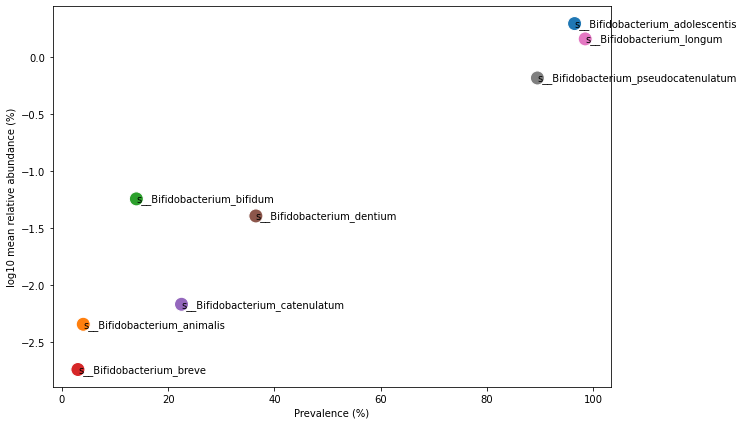

In [28]:
idx = [bool(re.search("Bifidobacterium",x)) for x in meta_df.index]
probiotics_df = meta_df.loc[idx,:]
abundance_prevalence_scatterplot(probiotics_df,output_path + 'Bifidobacterium_pv_mab.svg',figsize=(10,7),log_transform=True)

In [3]:
bifido_sig = pd.read_csv('/home/bruce1996/data/MCI/subtyping/bifido_subtype_sig_coefficient.txt',sep='\t',index_col=0)
lacto_sig = pd.read_csv('/home/bruce1996/data/MCI/subtyping/lacto_subtype_sig_coefficient.txt',sep='\t',index_col=0)

In [ ]:
import plotly.express as px

def signature_composition_piechart(input_df,output) :

    df = input_df.copy()
    df['Species'] = df.index
    df = df.melt(id_vars='Species')

    for prefix in np.unique(df['variable']) :
        plot_df = df.loc[np.where(df['variable'] == prefix,True,False),:]
        fig = px.pie(plot_df, values='value', names='Species', title='Signature composition : ' + prefix)
        fig.update_traces(textposition='inside',sort=False)
        fig.update_layout(uniformtext_minsize=20, uniformtext_mode=False)
        fig.write_image(output + prefix.replace(' ','_') + '.svg')
        fig.show()

input_df = lacto_sig.copy()
signature_composition_piechart(input_df,'/home/bruce1996/repo/Microbiome_health_indicator/')

### Subtyping

In [11]:
l_subtype_df = pd.read_csv('~/data/MCI/subtyping/Lactobacillus_group.csv')
b_subtype_df = pd.read_csv('~/data/MCI/subtyping/Bifidobacterium_group.csv')

In [12]:
def metaphlan_subtype(meta_df,subtype_df,genus,species_col,group_col) :

    subtype_dict = dict()
    for i in range(subtype_df.shape[0]) :
        s = subtype_df[species_col][i]
        s = 's__' +s.replace(' ','_')
        type = subtype_df[group_col][i]
        if type == 'no phylogroup' :
            type = genus + '_others'
        else :
            type = type + '_' + 'subtype'
        
        subtype_dict[s] = type  

    idx = [bool(re.search(genus,x)) for x in meta_df.index]
    df = meta_df.loc[idx,:]

    idx = list()
    ## change species name to subtype name
    convert_dict = dict()
    for i in range(df.shape[0]) :
        if df.index[i] in subtype_dict.keys() :
            s = df.index[i]
            subtype = subtype_dict[s]
        elif df.index[i] == 's__Lactobacillus_casei_paracasei' :
            s = df.index[i]
            subtype = 'Lacticaseibacillus_subtype'
        else :
            s = df.index[i]
            subtype = genus + '_others'

        if subtype in convert_dict.keys() :
            convert_dict[subtype] = convert_dict[subtype] + [s]
        else :
            convert_dict[subtype] = [s]
        idx.append(subtype)

    df.index = idx
    meta_df = df.copy()
    meta_df['subtype'] = df.index
    meta_df = meta_df.groupby('subtype').agg('sum')
    meta_df.index.name = None

    return meta_df,convert_dict

In [21]:
l_df,l_d = metaphlan_subtype(meta_df,l_subtype_df,'Lactobacillus','species','phylogroup')
normal_l_df = pd.read_csv("/home/bruce1996/data/MCI/result/normal/abundance_matrix/lactobacillus_abundance_matrix.txt",sep = '\t',index_col=0)
mci_l_df = pd.read_csv("/home/bruce1996/data/MCI/result/MCI/abundance_matrix/lactobacillus_abundance_matrix.txt",sep = '\t',index_col=0)

### NMF

In [8]:
from sklearn.decomposition import NMF

def finger_print_proportion(x,w,h):
    n_finger_print = w.shape[1]
    n_sample = w.shape[0]
    proportion_matrix = np.zeros([n_sample,n_finger_print+1])

    for i in range(n_sample) :
        total = sum(x[i,:])
        accum = 0
        if total == 0 :
            pass
        else :
            for j in range(n_finger_print) :
                ab = sum(np.dot(w[i,j],h[j,:]))
                proportion_matrix[i,j] = ab / total
                accum += (ab / total)

        proportion_matrix[i,-1] = 1 - accum

    return proportion_matrix

In [9]:
def fit_signature(denovo_df,fit_df,k,prefix) :
    X = denovo_df.T.to_numpy()
    x = fit_df.T.to_numpy()
    nmf_model = NMF(n_components=k, init='random', random_state=0)
    nmf_model.fit(X)
    w = nmf_model.transform(x)
    H = nmf_model.components_

    finger_print_matrix = finger_print_proportion(x,w,H)
    index = [prefix + ' signature' + str(x) for x in range(1,k+1)]
    sig_coefficient = pd.DataFrame(H,index = index , columns=fit_df.index)
    index.append(prefix + ' residual')

    finger_print_df = pd.DataFrame(finger_print_matrix.T,index=index,columns=denovo_df.columns)

    return finger_print_df,sig_coefficient

In [7]:
from matplotlib import cm

def plot_signature(H,prefix,subplot_x,subplot_y,fig_output,figsize = (12,6)) :
    n_sig ,n_feature = H.shape
    cmap = cm.Set2(np.linspace(0, 1, 7))
    fig,axes = plt.subplots(subplot_x,subplot_y,figsize=figsize)
    for idx,axs in enumerate(axes.ravel()) :
        x = H.iloc[idx,:]
        axs.bar(np.arange(n_feature),x,color = cmap)
        axs.set_xticks(np.arange(n_feature))
        axs.set_xticklabels(H.columns,rotation=90)
        axs.title.set_text(prefix + ' ' + str(idx+1))
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig(fig_output,dpi=300,bbox_inches='tight')
    plt.show()

In [5]:
b_sig = pd.read_csv('~/data/MCI/subtyping/bifido_subtype_sig_coefficient.txt',sep='\t',index_col=0)
l_sig = pd.read_csv('~/data/MCI/subtyping/lacto_subtype_sig_coefficient.txt',sep='\t',index_col=0)

l_sig = l_sig.T

l_df = pd.read_csv("~/data/MCI/subtyping/lacto_subtype_ab_matrix.txt",sep='\t',index_col=0)
b_df = pd.read_csv("~/data/MCI/subtyping/bifido_ab_matrix.txt",sep='\t',index_col=0)

idx = np.where(metadata['Diagnosis'] == 'MCI',True,False)
l_mci = l_df.loc[:,idx]
l_normal = l_df.loc[:,~idx]

b_mci = b_df.loc[:,idx]
b_normal = b_df.loc[:,~idx]

In [86]:
tmp,b_mci_sig = fit_signature(b_mci,b_mci,3,'Bifidobacterium')
tmp,l_mci_sig = fit_signature(l_mci,l_mci,3,'Lactobacillus')

tmp,b_normal_sig = fit_signature(b_normal,b_normal,3,'Bifidobacterium')
tmp,l_normal_sig = fit_signature(l_normal,l_normal,3,'Lactobacillus')

/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [65]:
b_sig_df,b_sig = fit_signature(b_df,b_df,3,'Bifidobacterium')
l_sig_df,l_sig = fit_signature(l_df,l_df,3,'Lactobacillus')

b_sig.to_csv('~/data/MCI/subtyping/bifido_subtype_sig_coefficient.txt',sep='\t')
l_sig.T.to_csv('~/data/MCI/subtyping/lacto_subtype_sig_coefficient.txt',sep='\t')

### heatmap

In [46]:
b_sig_df = pd.read_csv('~/data/MCI/subtyping/bifido_subtype_sig_matrix.txt',sep='\t',index_col=0)
l_sig_df = pd.read_csv('~/data/MCI/subtyping/lacto_subtype_sig_matrix.txt',sep='\t',index_col=0)
sig_df = pd.concat([l_sig_df,b_sig_df])
sig_df = sig_df.loc[:,metadata.index]

idx = np.where((metadata['Diagnosis'] == 'MCI'),True,False)
n_sig_df = sig_df.loc[:,idx]

n_metadata = metadata.loc[idx,:]

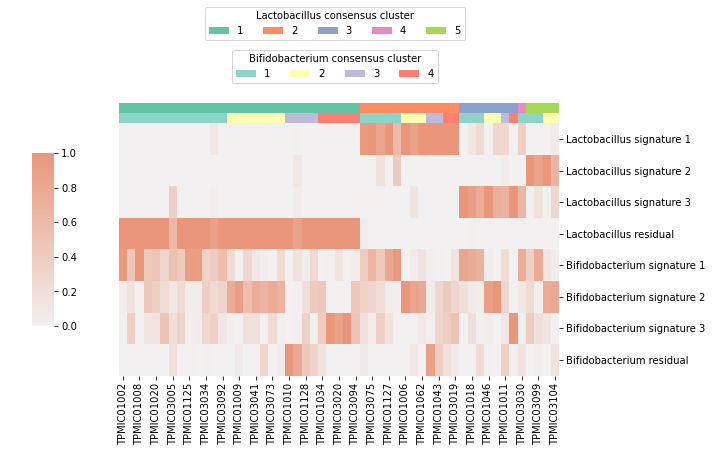

In [48]:
from matplotlib import cm
from matplotlib.pyplot import gcf

metadata_df = n_metadata.sort_values(by=['Lactobacillus_cluster','Bifidobacterium_cluster'])

l_cluster = metadata_df['Lactobacillus_cluster'].values
l_cluster_lut = dict(zip( set(l_cluster),  [cm.Set2(x) for x in range(10)] ))
l_cluster_colors = pd.Series(l_cluster).map(l_cluster_lut)
l_cluster_colors.index = metadata_df.index

b_cluster = metadata_df['Bifidobacterium_cluster'].values
b_cluster_lut = dict(zip( set(b_cluster),  [cm.Set3(x) for x in range(10)] ))
b_cluster_colors = pd.Series(b_cluster).map(b_cluster_lut)
b_cluster_colors.index = metadata_df.index

plot_df = n_sig_df.loc[:,metadata_df.index]

cmap = sns.light_palette("darksalmon", as_cmap=True)
#cmap = sns.diverging_palette(240, 10, n=9,as_cmap=True)

g = sns.clustermap(plot_df, cmap=cmap,vmin=0, vmax=1,  cbar_kws={"shrink": .3},
                row_cluster=False, 
                col_cluster=False,
                col_colors=[l_cluster_colors[plot_df.columns],b_cluster_colors[plot_df.columns]],
                linewidths=0, figsize=(10, 6))
g.ax_cbar.set_position((0.05, .3, .03, .4))

for label in set(l_cluster):
    g.ax_col_dendrogram.bar(0, 0, color=l_cluster_lut[label], label=label, linewidth=0)
l1 = g.ax_col_dendrogram.legend(title='Lactobacillus consensus cluster', loc="center", ncol=5, bbox_to_anchor=(0.47, 1.0), bbox_transform=gcf().transFigure)

for label in set(b_cluster):
    g.ax_row_dendrogram.bar(0, 0, color=b_cluster_lut[label], label=label, linewidth=0)
l2 = g.ax_row_dendrogram.legend(title='Bifidobacterium consensus cluster', loc="center", ncol=5, bbox_to_anchor=(0.47, .9), bbox_transform=gcf().transFigure)

plt.savefig(output_path + 'mci_sample_signature_heatmap_sort_by_lacto.svg',dpi = 300,bbox_inches = 'tight',format = 'svg')

### different between cluster (Taxonomy composition)

In [63]:
import itertools
from scipy.spatial.distance import squareform,braycurtis

In [69]:
metaphlan_output = "/home/bruce1996/data/MCI/metaphlan_result/formated_mci_metaphlan_table.txt"
meta_df = pd.read_csv(metaphlan_output,sep = '\t',index_col=0)
meta_df.columns = [x.split('_')[0] for x in meta_df.columns]

consensus_cluster = pd.read_csv('/home/bruce1996/data/MCI/subtyping/consensus_clustering.txt',sep='\t',index_col=0)
metadata = pd.read_csv('/home/bruce1996/data/MCI/metadata/MCI_label.txt',sep = '\t',index_col=0)
metadata = pd.concat([metadata,consensus_cluster],axis=1)

meta_df = meta_df.loc[:,metadata.index]

In [70]:
idx = np.where(metadata['Diagnosis'] =='MCI',True,False)
meta_mci = meta_df.loc[:,idx]
label = metadata.loc[idx,:]

label = label.sort_values(by='cluster')
meta_mci = meta_mci.loc[:,label.index]

idx = [bool(re.search('Lactobacillus|Bifidobacterium',x)) for x in meta_mci.index ]
meta_pro_mci = meta_mci.loc[idx,:]

In [77]:
def BrayCurtis(X):
    '''
    compute Bray-Curtis dissimilarity.
    Args:
      X: input N x K data matrix. N ... the number of samples, K ... the number of features.
    Return:
      N x N data matrix. The value of (i,j) shows the distance between sample-i and sample-j.
    '''
    X = np.array(X)
    n_samples = X.shape[0]
    n_distance = int(n_samples * (n_samples - 1) / 2)
    d_array = np.zeros((n_distance))
    for i, (idx1, idx2) in enumerate(itertools.combinations(range(n_samples),2)):
        d_array[i] = braycurtis(X[idx1], X[idx2])
    return squareform(d_array)

In [19]:
bc_dmartix = BrayCurtis(meta_df.T)
bc_dmartix = pd.DataFrame(bc_dmartix,index=meta_df.columns,columns=meta_df.columns)

unifracd_matrix = pd.read_csv("/home/bruce1996/data/MCI/metaphlan_result/weighted_unifrac_distance_matrix.txt",sep='\t')
unifracd_matrix.index = [x.split('_')[0] for x in unifracd_matrix.index]
unifracd_matrix.columns = [x.split('_')[0] for x in unifracd_matrix.columns]

In [74]:
from skbio.stats.ordination import pcoa
from sklearn.manifold import MDS
import seaborn as sns

In [75]:
def pcoa_scatterplot(dmatrix,metadata,hue,title,output_path,style=None) :
    '''
    dmatrix : dataframe, distance matrix with index & columns
    metadata : dataframe, row as sample ,columns as feature
    '''
    x = dmatrix.to_numpy()
    pcoa_r = pcoa(x,number_of_dimensions=2)
    pcoa_df = pcoa_r.samples
    pcoa_df.index = dmatrix.index
    pc1_exp,pc2_exp = round(100*pcoa_r.proportion_explained,2)
    pcoa_df = pd.concat([pcoa_df,metadata],axis=1)

    plt.figure(figsize=(8,6))
    if style != None :
        sns.scatterplot(data=pcoa_df,x= 'PC1',y='PC2',hue=hue,style='Diagnosis',palette="Set2",s=100)
    else :
        sns.scatterplot(data=pcoa_df,x= 'PC1',y='PC2',hue=hue,palette="Set2")

    xlabel = "PCoA1 (" + str(pc1_exp) + "%)"
    ylabel = "PCoA2 (" + str(pc2_exp) + "%)"
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1.1, 1))
    plt.title(title)
    plt.savefig(output_path,dpi = 300,bbox_inches = 'tight')

def mds_scatterplot(dmatrix,metadata,hue,title,output_path,style=None) :
    '''
    dmatrix : dataframe, distance matrix with index & columns
    metadata : dataframe, row as sample ,columns as feature
    '''
    x = dmatrix.to_numpy()
    mds = MDS(n_components=2,dissimilarity='precomputed')
    mds_r = mds.fit_transform(x)
    mds_df = pd.DataFrame(mds_r,index = dmatrix.index)
    mds_df.columns = ['MDS1','MDS2']
    mds_df = pd.concat([mds_df,metadata],axis=1)

    plt.figure(figsize=(8,6))
    if style != None :
        sns.scatterplot(data=mds_df,x= 'MDS1',y='MDS2',hue=hue,style='Diagnosis',palette="Set2",s=100)
    else :
        sns.scatterplot(data=mds_df,x= 'MDS1',y='MDS2',hue=hue,palette="Set2")

    plt.legend(bbox_to_anchor=(1.1, 1))
    plt.title(title)
    plt.savefig(output_path,dpi = 300,bbox_inches = 'tight')

/home/bruce1996/anaconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.1791767762414701 and the largest is 4.089394035714513.
  warn(


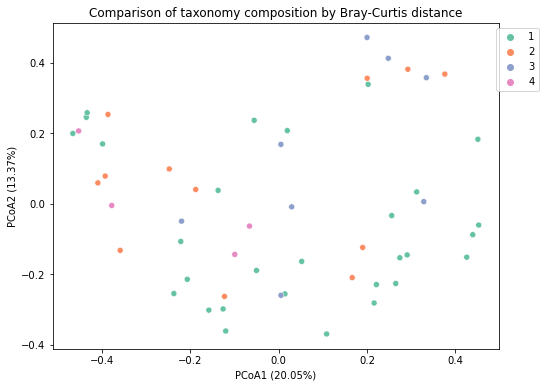

In [79]:
bc_dmartix = BrayCurtis(meta_pro_mci.T)
bc_dmartix = pd.DataFrame(bc_dmartix,index=meta_pro_mci.columns,columns=meta_pro_mci.columns)

pcoa_scatterplot(bc_dmartix,label,hue='cluster',title="Comparison of taxonomy composition by Bray-Curtis distance",output_path = output_path + 'bray_distance_pcoa.png')

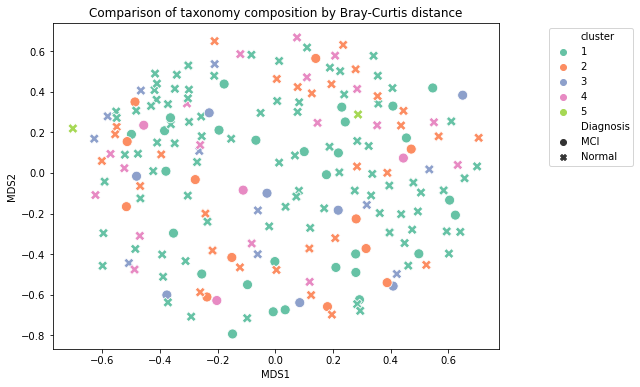

In [106]:
mds_scatterplot(bc_dmartix,metadata,hue='cluster',style='Diagnosis',title="Comparison of taxonomy composition by Bray-Curtis distance",output_path = output_path + 'bray_cutris_distance_mds.png')